In [24]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import os
from PIL import Image  
from scipy import sparse
from scipy.sparse import linalg
%matplotlib inline 

#### Utility functions

In [25]:
def readFolderImages(folder_path):
    file_lst = []
    for files in os.listdir(folder_path):
        if os.path.splitext(files)[1] == '.jpg':
            file_lst.append(folder_path+files)
    return file_lst

def plotRGB(image,rgb=None):
    plt.figure()
    if rgb:
        plt.imshow(image[:,:,[2,1,0]])
    else:
        plt.imshow(image,cmap="gray")
    plt.show()

def plotImages(image_lst, RGB=False, path=False, gray=False):
    n = len(image_lst)
    plt.figure()
    for i in range(1,n+1):
        plt.subplot(1,n,i)
        img = image_lst[i-1]
        if path:
            img = cv2.imread(image_lst[i-1])
        if RGB: 
            img = img[:,:,[2,1,0]]
        if gray:
            if len(img.shape)==3:
                img = img[:,:,[2,1,0]]
                img = img[:,:,0]
            plt.imshow(img, cmap ='gray')
        else:
            plt.imshow(img)
    plt.show()

# get the contour points from a mask input
def getVerticesfromMask(mask):
    gray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)  
    ret, binary = cv2.threshold(gray,127,255,cv2.THRESH_BINARY) 
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours[0]

# draw the contour of the polygon on the image
def drawContours(image,polygon_vertices,plot,rgb):
    contour_img = cv2.drawContours(image, [polygon_vertices], -1, (144, 238, 144), 5)
    if plot:
        plotRGB(contour_img,rgb)
    return contour_img

# generate binary mask through a list of contour points
def makeMaskByVertices(image_shape,polygon_vertices,save_name=None):
    zeros = np.zeros(image_shape, np.uint8)
    mask = cv2.fillPoly(zeros, [polygon_vertices], (255, 255, 255))
    plotRGB(mask)
    if save_name!=None:
        cv2.imwrite(save_name, mask)
    return mask

def resizeAndSave(image,hw,name):
    img = cv2.imread(image)
    img = cv2.resize(img,(hw[1],hw[0]))
    cv2.imwrite(name,img)
    return img

def prePadding(image):
    pad_img = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value = 0)
    return pad_img

class makeMaskByHand:
    def __init__(self, image_path, save_name, max_count = 10):
        cv2.namedWindow('src')
        self.image_path = image_path
        self.image = cv2.imread(image_path)
        self.save_name = save_name
        self.max_count = max_count
        self.points_count = 0
        self.chosen_points = []
    def OnMouseAction(self,event, x, y, flags, param):
        img = self.image.copy()  
        if event == cv2.EVENT_LBUTTONDOWN:  
            self.chosen_points.append([x, y])  
            self.points_count += 1
            cv2.circle(img, (x, y), 8, (144, 238, 144), 2)
            for i in range(len(self.chosen_points) - 1):
                cv2.line(img, tuple(self.chosen_points[i]), tuple(self.chosen_points[i + 1]), (0, 0, 255), 2)
            if (self.points_count == self.max_count):
                polygon_vertices = np.array([self.chosen_points], np.int32).reshape((-1, 1, 2))
                makeMaskByVertices(self.image.shape,polygon_vertices,self.save_name)
            cv2.imshow('src', img)
    def makeMask(self):
        cv2.setMouseCallback('src', self.OnMouseAction)
        cv2.imshow('src', self.image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

def getboundRec(mask_path):
    mask = cv2.imread(mask_path)
    gray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)  
    contours, _ = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(contours[0]) 
    return (mask.shape[0],mask.shape[1]),x, y, w, h 

# The size of the source image is similar to the size of the region that we made out. 
# Now, we need to correct its shape to match the bounding rectangle of the region. 
# Then we need to pad it to make it have the same shape as the destination image.
def resizeSource(mask_path,source_path,output_path):
    shape,x, y, w, h = getboundRec(mask_path)
    source = cv2.imread(source_path)
    source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
    source = cv2.resize(source,(w,h))
    source = cv2.copyMakeBorder(source, y, shape[0]-h-y, x, shape[1]-w-x, cv2.BORDER_CONSTANT, value = 0)
    source = source[:,:,[2,1,0]]
    cv2.imwrite(output_path,source)
    return source


### 1 Select a grayscale image (25 points)

- Mark out a region R using a polygon (you can use functions like matplotlib.path and cv2.fillpolly) (5 points).

In [26]:
# visualize the region by a mask
def visualizeRegion(image,vertices=True,vertices_lst=None,mask=None,plot=True,rgb=True):
    if len(image.shape) == 2:
            image = np.stack((image,)*3, axis=-1)
    if vertices:
        return drawContours(image,vertices_lst)
    else:
        vertices_lst = getVerticesfromMask(mask)
        return drawContours(image,vertices_lst,plot,rgb)        

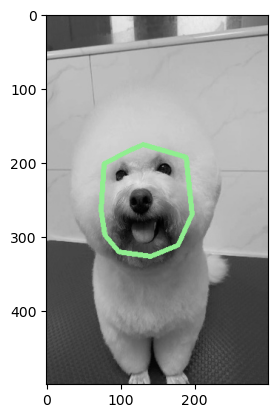

In [27]:
'''  
We can store the region information in a binary image (mask) for making out a region.
To make a mask in this code, follow the below steps. They are executed separately, 
and you may need to restart the Jupyter kernel after executing step1 and step3. 

(Resize and pad the source image such that it can be located in the region chosen from the destination image. 
And then make a new detailed mask of the padded source image.)

step0(optional):
resizeAndSave("dst.jpg",(400,400),"dst.jpg")
step1:
maskMaker = makeMaskByHand("dst.jpg","dst_mask.jpg")
maskMaker.makeMask()
step2:
resizeSource("dst_mask.jpg","src.jpg","src_padded.jpg")
step3:
maskMaker = makeMaskByHand("src_padded.jpg","src_padded_mask.jpg")
maskMaker.makeMask()
'''

img = cv2.imread("images/dog/dog.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# use the pre-made mask
mask = cv2.imread("images/dog/dog_mask.jpg")   
v = visualizeRegion(img,vertices=False,vertices_lst=None,mask=mask)

- Remove the selected region and fill it in using Equation (2) in the paper (10 points). 

In [28]:
class grayscaleEQ2:
    def __init__(self, mask, dst):
        '''   
        dst: the destination image from which a selected region will be removed
        mask: the corresponding binary image has the same shape of the destination image 
        
        '''
        self.mask = cv2.imread(mask)
        # read the grayscale image
        self.dst = cv2.imread(dst,cv2.IMREAD_GRAYSCALE)
        # a list stores the coordinates of pixels in the omega region
        self.interior_coord_lst = []
        # the whole image shape
        self.height,self.width = self.mask.shape[0],self.mask.shape[1]
        # Use the coordinate system to record the order of pixel points in the omega region
        self.n_indices = np.zeros((self.height,self.width),dtype=int)
        self.b = None
        self.A = None
        self.result = None
    
    # find the interior pixels coordinates and their indices through the binary mask (0/255)    
    def getInterior(self):
        idx = 0 
        for h in range(self.height):
            for w in range(self.width):
                if self.mask[h,w,0] == 255:
                    self.interior_coord_lst.append([h,w])
                    self.n_indices[h,w]=idx
                    idx += 1

    # Af = b
    def getPossionEquation(self):
        interior_coord_lst = self.interior_coord_lst
        n_indices = self.n_indices
        n = len(interior_coord_lst)
        self.b = np.zeros([n, 1])
        self.A = np.zeros([n, n])   
        for i in range(n):
            x = interior_coord_lst[i][0]
            y = interior_coord_lst[i][1]

            #######################################################################################
            # assume all neighborhoods of the interior pixels are in the image 
            #(omega does not extend to the edge of the pixel grid)
            #|N_p|=4
            self.A[i,i] = 4

            # determine the location of the four neighbourhoods of p 
            # Analyze in turn whether the four neighbors of p are inside the omega or at the boundary,
            #if the neighbor is inside the omega, modify the corresponding value of A (-f_q: -1)
            #if the neighbor is at the boundary, add f_q^* to the corresponding location of b

            # q \in N_{p} \cap \Omega
            if self.mask[x-1, y, 0] == 255: # the left neighborhood
                self.A[i,n_indices[x-1, y]] = -1
            # q \in N_{p} \cap \partial \Omega
            else:
                self.b[i] = self.dst[x-1, y]

            if self.mask[x+1, y, 0] == 255: # the right neighborhood
                self.A[i,n_indices[x+1, y]] = -1
            else:
                self.b[i] = self.dst[x+1, y]

            if self.mask[x, y-1, 0] == 255: # the lower neighborhood
                self.A[i,n_indices[x, y-1]] = -1
            else:
                self.b[i] = self.dst[x, y-1]

            if self.mask[x, y+1, 0] == 255: # the upper neighborhood
                self.A[i,n_indices[x, y+1]] = -1
            else:
                self.b[i] = self.dst[x, y+1]
            #######################################################################################

    def possionSolver(self):
        # Af = b
        # store a sparse matrix 
        self.A = sparse.lil_matrix(self.A, dtype=int)
        # Use Conjugate Gradient iteration to solve A x = b
        f = linalg.cg(self.A, self.b)[0]
        result_image = self.dst
        for i in range(len(self.interior_coord_lst)):
            x, y = self.interior_coord_lst[i]
            result_image[x, y] = np.clip(f[i], 0, 255)
        return result_image

    def getResult(self):
        self.getInterior()
        self.getPossionEquation()
        result_image = self.possionSolver()
        self.result = result_image
        return result_image

    def showResult(self):
        plt.figure()
        plt.imshow(self.result, cmap ='gray')
        plt.show()


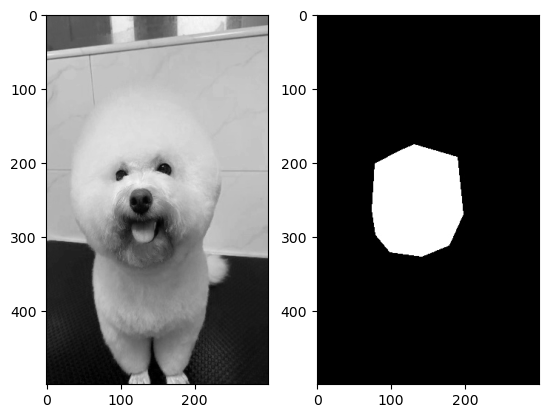

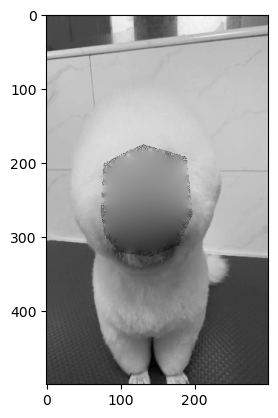

In [29]:
dst = "images/dog/dog.jpg"
mask = "images/dog/dog_mask.jpg"

image_lst = [dst,mask]
plotImages(image_lst, RGB=False, path=True, gray=True)

eq2 = grayscaleEQ2(mask,dst)
eq2.getResult()
eq2.showResult()


- Test the method in smooth regions and also in regions with edge (high-frequency) (5 points).

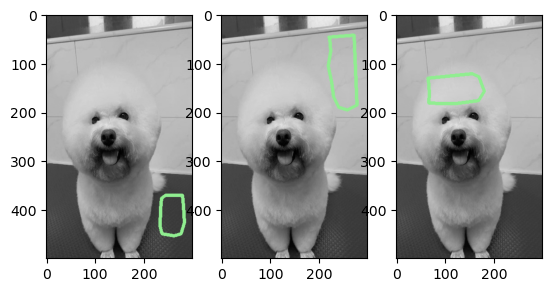

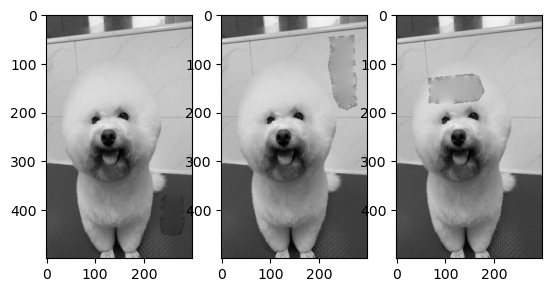

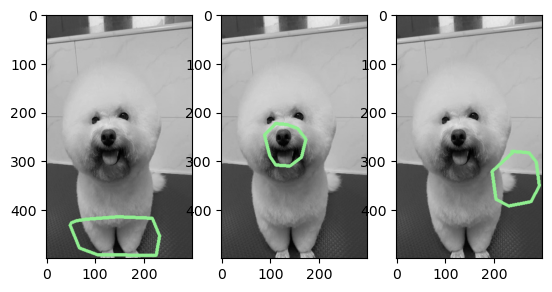

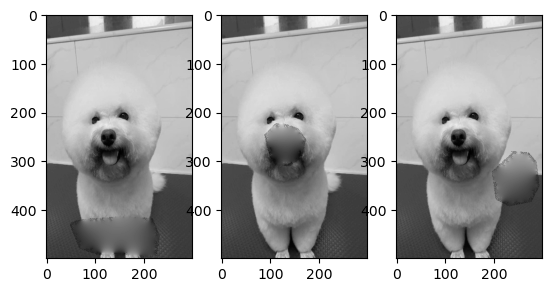

In [30]:
dst = "images/dog/dog.jpg"
smooth_test = readFolderImages("images/dog/smooth/")
edges_test = readFolderImages("images//dog/edges/")
smooth_result = []
edges_result = []
smooth_makeOut = []
edges_makeOut = []


for smooth in smooth_test:
    result = grayscaleEQ2(smooth,dst).getResult()
    smooth_result.append(result)
    makeOut = visualizeRegion(cv2.imread(dst,0),vertices=False,vertices_lst=None,mask=cv2.imread(smooth),plot=False)
    smooth_makeOut.append(makeOut)


for edges in edges_test:
    result = grayscaleEQ2(edges,dst).getResult()
    edges_result.append(result)
    makeOut = visualizeRegion(cv2.imread(dst,0),vertices=False,vertices_lst=None,mask=cv2.imread(edges),plot=False)
    edges_makeOut.append(makeOut)


plotImages(smooth_makeOut,RGB=False)
plotImages(smooth_result,gray=True)
plotImages(edges_makeOut,RGB=False)
plotImages(edges_result,gray=True)

-   report the behavior as the size of the selected region increases (5 points).

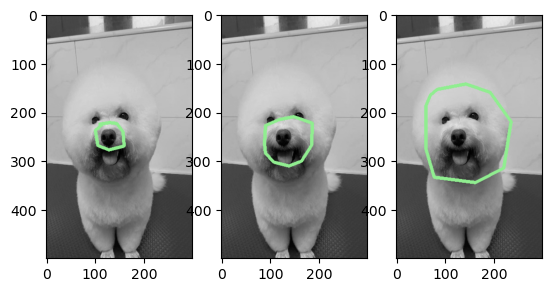

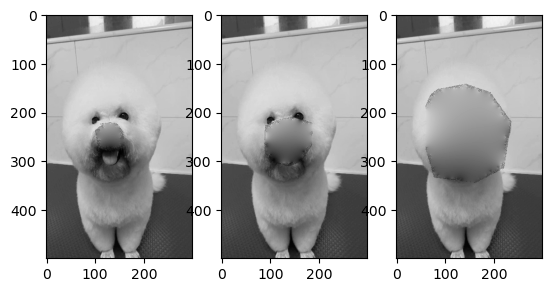

In [31]:
dst = "images/dog/dog.jpg"
size_test = readFolderImages("images/dog/size/")
size_test.sort()
size_result = []
size_makeOut = []

for size in size_test:
    result = grayscaleEQ2(size,dst).getResult()
    size_result.append(result)
    makeOut = visualizeRegion(cv2.imread(dst,0),vertices=False,vertices_lst=None,mask=cv2.imread(size),plot=False)
    size_makeOut.append(makeOut)
 

plotImages(size_makeOut,RGB=False)
plotImages(size_result,gray=True)

### 2 Seamless cloning for grayscale images (50 points)

- (a) Importing gradients (20 points).

In [32]:
class grayscaleSeamlessCloning:
    def __init__(self, mask, dst,src):
   
        self.mask = cv2.imread(mask)
        self.dst = cv2.imread(dst)
        # read the source image(source function g)
        self.src = cv2.imread(src)

        if self.dst.shape[2] == 3:
            self.dst = cv2.cvtColor(self.dst, cv2.COLOR_BGR2GRAY)
        if self.src.shape[2] == 3:
            self.src = cv2.cvtColor(self.src, cv2.COLOR_BGR2GRAY)
        self.interior_coord_lst = []
        self.height,self.width = self.mask.shape[0],self.mask.shape[1]
        self.n_indices = np.zeros((self.height,self.width),dtype=int)
        self.b = None
        self.A = None
        self.result = None

    def getInterior(self):
        idx = 0 
        for h in range(self.height):
            for w in range(self.width):
                if self.mask[h,w,0] == 255:
                    self.interior_coord_lst.append([h,w])
                    self.n_indices[h,w]=idx
                    idx += 1

    def getPossionEquation(self):
        interior_coord_lst = self.interior_coord_lst
        n_indices = self.n_indices
        n = len(interior_coord_lst)
        self.b = np.zeros([n, 1])
        self.A = np.zeros([n, n])   
        for i in range(n):
            x = interior_coord_lst[i][0]
            y = interior_coord_lst[i][1]
           
            # \Delta f=\operatorname{div} \mathbf{v} \text { over } \Omega
            # \sum_{q \in N_{p}} v_{p q}
            # v_pq = g_p - g_q
            self.b[i] = 4 * self.src[x,y] - self.src[x-1,y] - self.src[x+1,y] - self.src[x,y -1] - self.src[x,y+1]
            
            ############# same as before #################
            self.A[i,i] = 4
            if self.mask[x-1, y, 0] == 255:
                self.A[i,n_indices[x-1, y]] = -1
            else:
                self.b[i] += self.dst[x-1, y]

            if self.mask[x+1, y, 0] == 255:
                self.A[i,n_indices[x+1, y]] = -1
            else:
                self.b[i] += self.dst[x+1, y]

            if self.mask[x, y-1, 0] == 255:
                self.A[i,n_indices[x, y-1]] = -1
            else:
                self.b[i] += self.dst[x, y-1]

            if self.mask[x, y+1, 0] == 255:
                self.A[i,n_indices[x, y+1]] = -1
            else:
                self.b[i] += self.dst[x, y+1]
            ###############################################
    
    def possionSolver(self):
        self.A = sparse.lil_matrix(self.A, dtype=int)
        f = linalg.cg(self.A, self.b)[0]
        result_image = self.dst
        for i in range(len(self.interior_coord_lst)):
            x, y = self.interior_coord_lst[i]
            result_image[x, y] = np.clip(f[i], 0, 255)
        return result_image

    def getResult(self):
        self.getInterior()
        self.getPossionEquation()
        result_image = self.possionSolver()
        self.result = result_image
        return self.result

    def showResult(self):
        plt.figure()
        plt.imshow(self.result, cmap ='gray')
        plt.show()

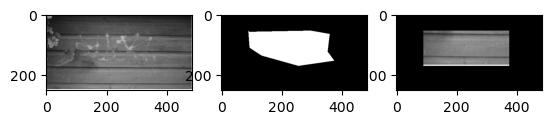

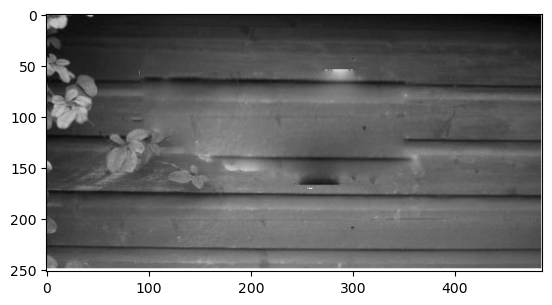

In [33]:
# Reproduce the concealment effect in the paper
dst = "images/paper_images/Concealment/concealment.jpg"
mask = "images/paper_images/Concealment/concealment_dst_mask.jpg"
src = "images/paper_images/Concealment/concealment_src_padded.jpg"

image_lst = [dst,mask,src]
plotImages(image_lst, RGB=False, path=True, gray=True)


gsc1 = grayscaleSeamlessCloning(mask,dst,src)
gsc1.getResult()
gsc1.showResult()

- (b) Mixing gradients (20 points).

In [34]:
class grayscaleMixedSeamlessCloning:
    def __init__(self, mask, dst,src):
        self.mask = cv2.imread(mask)
        self.dst = cv2.imread(dst,0)
        self.src = cv2.imread(src,0)
        self.interior_coord_lst = []
        self.height,self.width = self.mask.shape[0],self.mask.shape[1]
        self.n_indices = np.zeros((self.height,self.width),dtype=int)
        self.b = None
        self.A = None
        self.result = None

    def getInterior(self):
        idx = 0 
        for h in range(self.height):
            for w in range(self.width):
                if self.mask[h,w,0] == 255:
                    self.interior_coord_lst.append([h,w])
                    self.n_indices[h,w]=idx
                    idx += 1

    # \text { if }\left|\nabla f^{*}(\mathbf{x})\right|>|\nabla g(\mathbf{x})|
    def comapreLength(self,vector1,vector2):
        length1 = np.linalg.norm(vector1)
        length2 = np.linalg.norm(vector2)
        if length1>length2:
            return vector1         
        else:
            return vector2

    def getPossionEquation(self):
        interior_coord_lst = self.interior_coord_lst
        n_indices = self.n_indices
        n = len(interior_coord_lst)
        self.b = np.zeros([n, 1])
        self.A = np.zeros([n, n])   
        for i in range(n):
            x = interior_coord_lst[i][0]
            y = interior_coord_lst[i][1]

            ########### non-conservative guidance fields calculation #################################
            # f^star_gradient = f_p^star -  f_q^star
            N1_fstar = int(self.dst[x,y]) - int(self.dst[x-1,y])
            N2_fstar = int(self.dst[x,y]) - int(self.dst[x+1,y])
            N3_fstar = int(self.dst[x,y]) - int(self.dst[x,y-1])
            N4_fstar = int(self.dst[x,y]) - int(self.dst[x,y+1])

            # g_gradient = g_p - g_q
            N1_g = int(self.src[x,y])- int(self.src[x-1,y])
            N2_g = int(self.src[x,y]) - int(self.src[x+1,y])
            N3_g = int(self.src[x,y]) - int(self.src[x,y-1])
            N4_g = int(self.src[x,y]) - int(self.src[x,y+1])

            # v_pq = max(f^star_gradient, g_gradient)
            guidance_field = self.comapreLength(N1_fstar,N1_g)+self.comapreLength(N2_fstar,N2_g)+self.comapreLength(N3_fstar,N3_g)+\
                self.comapreLength(N4_fstar,N4_g)
            
            self.b[i] = guidance_field
            ##########################################################################################
            
            ############# same as before #################
            self.A[i,i] = 4
            if self.mask[x-1, y, 0] == 255:
                self.A[i,n_indices[x-1, y]] = -1
            else:
                self.b[i] += self.dst[x-1, y]

            if self.mask[x+1, y, 0] == 255:
                self.A[i,n_indices[x+1, y]] = -1
            else:
                self.b[i] += self.dst[x+1, y]

            if self.mask[x, y-1, 0] == 255:
                self.A[i,n_indices[x, y-1]] = -1
            else:
                self.b[i] += self.dst[x, y-1]

            if self.mask[x, y+1, 0] == 255:
                self.A[i,n_indices[x, y+1]] = -1
            else:
                self.b[i] += self.dst[x, y+1]
            ###############################################

    def possionSolver(self):
        self.A = sparse.lil_matrix(self.A, dtype=int)
        f = linalg.cg(self.A, self.b)[0]
        result_image = self.dst
        for i in range(len(self.interior_coord_lst)):
            x, y = self.interior_coord_lst[i]
            result_image[x, y] = np.clip(f[i], 0, 255)
        return result_image

    def getResult(self):
        self.getInterior()
        self.getPossionEquation()
        result_image = self.possionSolver()
        self.result = result_image
        return result_image

    def showResult(self):
        plt.figure()
        plt.imshow(self.result, cmap ='gray')
        plt.show()

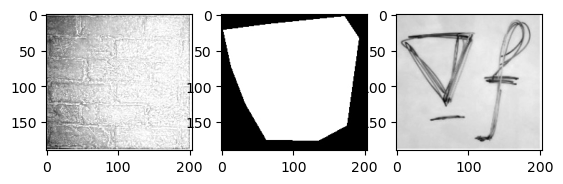

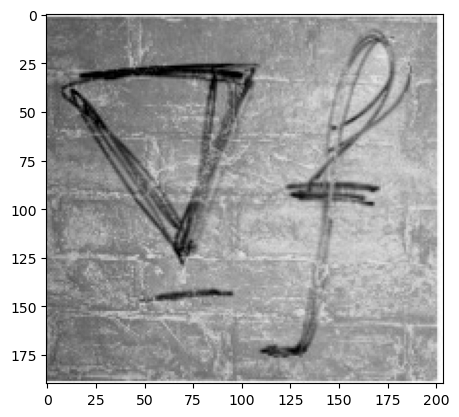

In [35]:
# Reproduce the results from the paper
dst = "images/paper_images/mixed/mixed_dst.jpg"
mask = "images/paper_images/mixed/mixed_mask.jpg"
src = "images/paper_images/mixed/mixed_src.jpg"

image_lst = [dst,mask,src]
plotImages(image_lst, RGB=False, path=True, gray=True)

gmsc1 = grayscaleMixedSeamlessCloning(mask,dst,src)
gmsc1.getResult()
gmsc1.showResult()


- Select two images you like to edit and show result that demoinstarted well the effect with one sentence of explanation for each (10 points).

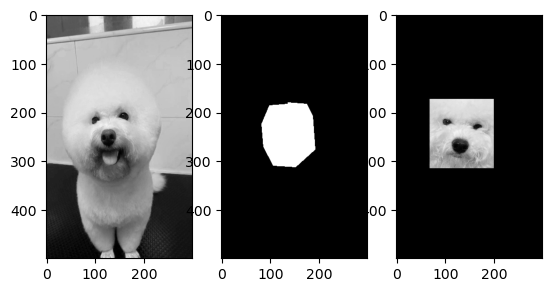

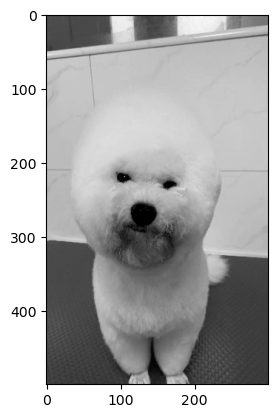

In [36]:
# normal grayscale seamless cloning

# Replace the facial expression of the dog on the source image.
dst = "images/dog/Expressions/dst.jpg"
mask = "images/dog/Expressions/src_padded_mask.jpg"
src = "images/dog/Expressions/src_padded.jpg"

image_lst = [dst,mask,src]
plotImages(image_lst, RGB=False, path=True, gray=True)

gsc2 = grayscaleSeamlessCloning(mask,dst,src)
gsc2.getResult()
gsc2.showResult()

- explanation:  
Introduce the constraint in the form of a guidance field which is the gradient of the source image function.

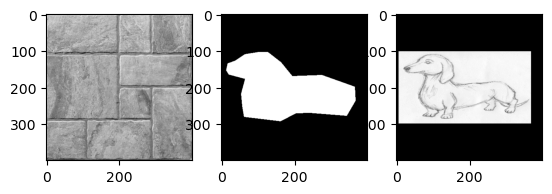

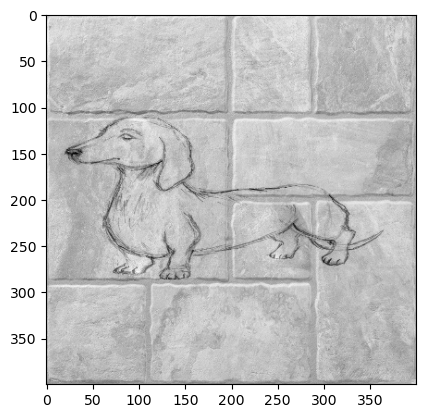

In [37]:
# grayscale mixed gradient seamless cloning

# insert the pencil drawing to the tile image.
dst = "images/tile/dst.jpg"
mask = "images/tile/src_padded_mask.jpg"
src = "images/tile/src_padded.jpg"

image_lst = [dst,mask,src]
plotImages(image_lst, RGB=False, path=True, gray=True)

gmsc2 = grayscaleMixedSeamlessCloning(mask,dst,src)
gmsc2.getResult()
gmsc2.showResult()

- explanation:  
The guidance field retains the larger of the gradients of the source or destination image functions.

### 3. Seamless cloning for color images (10 points)

In [38]:
class SeamlessCloning:
    def __init__(self, mask, dst, src):

        self.mask = np.array(Image.open(mask))
        self.dst = np.array(Image.open(dst))
        self.src = np.array(Image.open(src))

        self.interior_coord_lst = []
        self.height,self.width = self.mask.shape[0],self.mask.shape[1]
        self.n_indices = np.zeros((self.height,self.width),dtype=int)
        self.b = None
        self.A = None
        self.result = None

    def getInterior(self):
        idx = 0 
        for h in range(self.height):
            for w in range(self.width):
                if self.mask[h,w,0] == 255:
                    self.interior_coord_lst.append([h,w])
                    self.n_indices[h,w]=idx
                    idx += 1

    def getPossionEquation(self):
        interior_coord_lst = self.interior_coord_lst
        n_indices = self.n_indices
        n = len(interior_coord_lst)
        self.b = np.zeros([n, 3]) #rgb, 3 channels
        self.A = np.zeros([n, n])  
        for i in range(n):
            x = interior_coord_lst[i][0]
            y = interior_coord_lst[i][1]
          
            ################
            for j in range(3):
                self.b[i,j] = 4 * self.src[x,y,j] - self.src[x-1,y,j] - self.src[x+1,y,j] - self.src[x,y -1,j] - self.src[x,y+1,j]
            ################
            
           ############# same as before #################
            self.A[i,i] = 4
            if self.mask[x-1, y, 0] == 255:
                self.A[i,n_indices[x-1, y]] = -1
            else:
                for j in range(3):
                    self.b[i,j] += self.dst[x-1, y,j]

            if self.mask[x+1, y, 0] == 255:
                self.A[i,n_indices[x+1, y]] = -1
            else:
                for j in range(3):
                    self.b[i,j] += self.dst[x+1, y,j]

            if self.mask[x, y-1, 0] == 255:
                self.A[i,n_indices[x, y-1]] = -1
            else:
                for j in range(3):
                    self.b[i,j] += self.dst[x, y-1,j]

            if self.mask[x, y+1, 0] == 255:
                self.A[i,n_indices[x, y+1]] = -1
            else:
                for j in range(3):
                    self.b[i,j] += self.dst[x, y+1,j]
            ###############################################

    def possionSolver(self):
        self.A = sparse.lil_matrix(self.A, dtype=int)
        R = linalg.cg(self.A, self.b[:, 0])[0]
        G = linalg.cg(self.A, self.b[:, 1])[0]
        B = linalg.cg(self.A, self.b[:, 2])[0]
        result_image = self.dst
        for i in range(len(self.interior_coord_lst)):
            x, y = self.interior_coord_lst[i]
            result_image[x, y, 0] = np.clip(R[i], 0, 255)
            result_image[x, y, 1] = np.clip(G[i], 0, 255)
            result_image[x, y, 2] = np.clip(B[i], 0, 255)
        return result_image

    def getResult(self):
        self.getInterior()
        self.getPossionEquation()
        result_image = self.possionSolver()
        self.result = result_image
        return result_image

    def showResult(self):
        plt.figure()
        plt.imshow(self.result, cmap ='gray')
        plt.show()

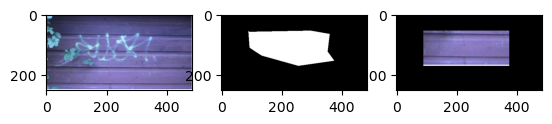

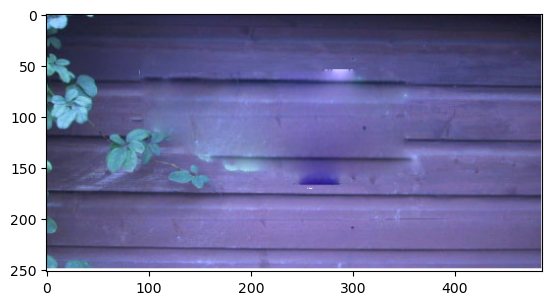

In [39]:
dst = "images/paper_images/Concealment/concealment.jpg"
mask = "images/paper_images/Concealment/concealment_dst_mask.jpg"
src = "images/paper_images/Concealment/concealment_src_padded.jpg"

image_lst = [dst,mask,src]
plotImages(image_lst, RGB=True, path=True, gray=False)


sc1 = SeamlessCloning(mask,dst,src)
sc1.getResult()
sc1.showResult()

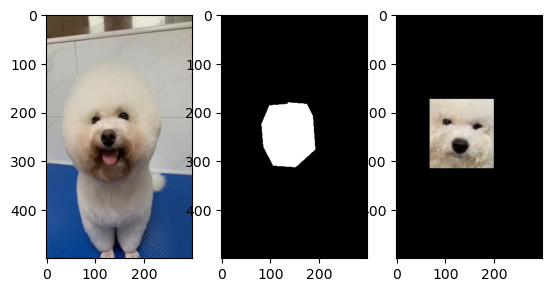

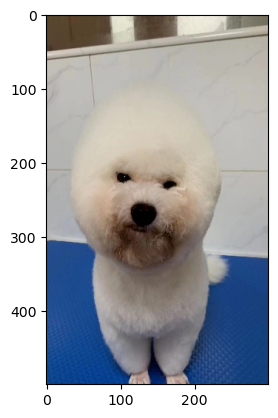

In [40]:
dst = "images/dog/Expressions/dst.jpg"
mask = "images/dog/Expressions/src_padded_mask.jpg"
src = "images/dog/Expressions/src_padded.jpg"

image_lst = [dst,mask,src]
plotImages(image_lst, RGB=True, path=True, gray=False)

sc2 = SeamlessCloning(mask,dst,src)
sc2.getResult()
sc2.showResult()

### 4 Selection editing effects (15 points)

In [41]:
class TextureFlattening:
    def __init__(self, mask, dst, threshold):
        
        self.mask = cv2.imread(mask)
        self.mask = cv2.cvtColor(self.mask, cv2.COLOR_BGR2RGB)
        self.dst = cv2.imread(dst)
        self.dst = cv2.cvtColor(self.dst, cv2.COLOR_BGR2RGB)

        self.interior_coord_lst = []
        self.height,self.width = self.mask.shape[0],self.mask.shape[1]
        self.n_indices = np.zeros((self.height,self.width),dtype=int)
        self.b = None
        self.A = None
        self.result = None
        self.threshold = threshold

    def getInterior(self):
        idx = 0 
        for h in range(self.height):
            for w in range(self.width):
                if self.mask[h,w,0] == 255:
                    self.interior_coord_lst.append([h,w])
                    self.n_indices[h,w]=idx
                    idx += 1

    def getPossionEquation(self):
        interior_coord_lst = self.interior_coord_lst
        n_indices = self.n_indices
        n = len(interior_coord_lst)
        self.b = np.zeros([n, 3])
        self.A = np.zeros([n, n])   
        for i in range(n):
            x = interior_coord_lst[i][0]
            y = interior_coord_lst[i][1]

            ############################################
            # The gradient of f^* is passed through a sparse sieve
            # Only retain gradients greater than this threshold
            # v_pq = f_p^star - f_q^star if f_p^star - f_q^star > threshold else 0
            for j in range(3):
                if abs(int(self.dst[x, y, j]) - int(self.dst[x-1, y, j])) > self.threshold:
                        self.b[i, j] += int(self.dst[x, y, j]) - int(self.dst[x-1, y, j]) 
                if abs(int(self.dst[x, y, j]) - int(self.dst[x+1, y, j])) > self.threshold:
                    self.b[i, j] += int(self.dst[x, y, j]) - int(self.dst[x+1, y, j]) 
                if abs(int(self.dst[x, y, j]) - int(self.dst[x, y-1, j])) > self.threshold:
                    self.b[i, j] += int(self.dst[x, y, j]) - int(self.dst[x, y-1, j]) 
                if abs(int(self.dst[x, y, j]) - int(self.dst[x, y+1, j])) > self.threshold:
                    self.b[i, j] += int(self.dst[x, y, j]) - int(self.dst[x, y+1, j]) 
            ###########################################

            ############# same as before #################
            self.A[i,i] = 4
            if self.mask[x-1, y, 0] == 255:
                self.A[i,n_indices[x-1, y]] = -1
            else:
                for j in range(3):
                    self.b[i,j] += self.dst[x-1, y,j]

            if self.mask[x+1, y, 0] == 255:
                self.A[i,n_indices[x+1, y]] = -1
            else:
                for j in range(3):
                    self.b[i,j] += self.dst[x+1, y,j]

            if self.mask[x, y-1, 0] == 255:
                self.A[i,n_indices[x, y-1]] = -1
            else:
                for j in range(3):
                    self.b[i,j] += self.dst[x, y-1,j]

            if self.mask[x, y+1, 0] == 255:
                self.A[i,n_indices[x, y+1]] = -1
            else:
                for j in range(3):
                    self.b[i,j] += self.dst[x, y+1,j]
            ###############################################
            
    def possionSolver(self):
        self.A = sparse.lil_matrix(self.A, dtype=int)
        R = linalg.cg(self.A, self.b[:, 0])[0]
        G = linalg.cg(self.A, self.b[:, 1])[0]
        B = linalg.cg(self.A, self.b[:, 2])[0]
        result_image = self.dst
        for i in range(self.b.shape[0]):
            x, y = self.interior_coord_lst[i]
            result_image[x, y, 0] = np.clip(R[i], 0, 255)
            result_image[x, y, 1] = np.clip(G[i], 0, 255)
            result_image[x, y, 2] = np.clip(B[i], 0, 255)
        return result_image

    def getResult(self):
        self.getInterior()
        self.getPossionEquation()
        result_image = self.possionSolver()
        self.result = result_image
        return result_image

    def showResult(self):
        plt.figure()
        plt.imshow(self.result)
        plt.show()

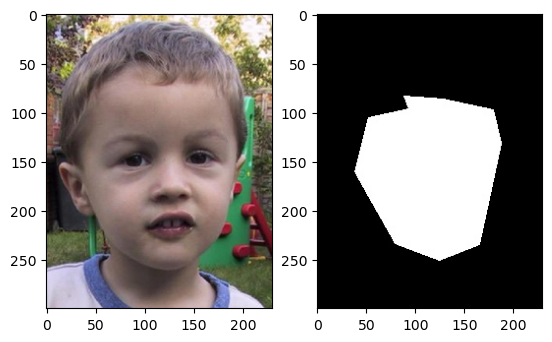

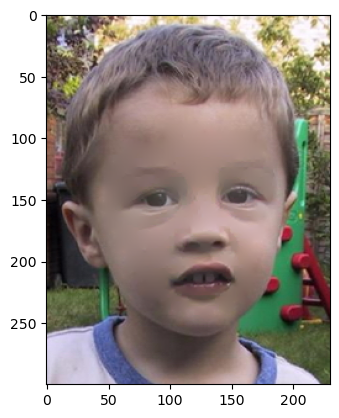

In [42]:
dst = "images/paper_images/boy/boy.jpg"
mask = "images/paper_images/boy/boy_mask.jpg"

image_lst = [dst,mask]
plotImages(image_lst, RGB=True, path=True, gray=False)

tf = TextureFlattening(mask,dst,7)
tf.getResult()
tf.showResult()